# data

In [7]:
#import libraries

import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,roc_curve, auc, plot_confusion_matrix, precision_recall_fscore_support, precision_recall_curve,confusion_matrix
from sklearn.metrics import classification_report
import plotly.express as px


from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from datetime import datetime
from matplotlib import pyplot


import matplotlib.font_manager as fm
path = '/home/AAA/Font/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=18)
fe = fm.FontEntry(fname='../Font/NanumGothic.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
plt.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
# sns.set_theme(font ='NanumGothic', rc = {'axes.unicode_minus' : False}, style ='darkgrid')
plt.rc("font", family = "NanumGothic")
sns.set(font="NanumGothic", 
rc={"axes.unicode_minus":False}, style='darkgrid')


pd.set_option('display.max_columns', 100) #pd 컬럼 결과 모두 출력
pd.set_option('display.max_rows', 500) #pd 행 결과 모두 출력
np.set_printoptions(threshold=np.inf) # 배열의 모두를 출력


# data 불러오기
raw_data = pd.read_csv('data_final.csv',encoding='cp949',index_col=0)
raw_df = raw_data.copy()
raw_df.info()


# 연속형 변수
data_num = raw_df.select_dtypes(exclude = object)

#범주형 변수
data_obj = raw_df.select_dtypes(include = object)
data_unique = pd.DataFrame({'col' : data_obj.columns})
list_unique = []

for i in range(len(data_obj.columns)):
    list_unique.append(data_obj.iloc[:, i].unique().tolist())
data_unique['unique'] = list_unique

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749907 entries, 0 to 1749906
Data columns (total 35 columns):
 #   Column        Dtype  
---  ------        -----  
 0   서비스이용일그룹      object 
 1   미디어그룹명        object 
 2   상품명그룹         object 
 3   구상품여부         object 
 4   약정종류          object 
 5   셋톱1개월이용안함     object 
 6   SVOD가입건수      object 
 7   유료채널가입그룹      object 
 8   가입경로명         object 
 9   약정종료          object 
 10  약정종료년월        object 
 11  총이용일수         int64  
 12  TV가입          int64  
 13  아날로그가입        int64  
 14  디지털가입         int64  
 15  총인터넷가입        int64  
 16  기가인터넷가입건수     int64  
 17  번들상품가입여부      object 
 18  디지털기가가입여부     object 
 19  디지털아날로그여부     object 
 20  TV인터넷가입건수     float64
 21  VOC1개월발생여부    object 
 22  이메일수신분류명      object 
 23  SMS수신분류명      object 
 24  1개월평균채널시청시간   float64
 25  채널이용증가여부      object 
 26  선호채널          object 
 27  키즈컨텐츠PV       float64
 28  키즈컨텐츠이용여부     object 
 29  키즈컨텐츠VOD이용여부  float64
 30  1달이용금액        int6

In [2]:
# tv가입 1,2,3
raw_df['TV가입'] = np.where(raw_df['TV가입'] == 1, '1건', np.where(raw_df['TV가입'] == 2, '2건', '3건 이상'))

#아날로그가입 0,1
raw_df['아날로그가입'] = np.where(raw_df['아날로그가입'] == 0, '0건', '1건 이상')

#디지털가입 1,2,3
raw_df['디지털가입'] = np.where(raw_df['디지털가입'] == 1, '1건', np.where(raw_df['디지털가입'] == 2, '2건', '3건 이상'))

# 총인터넷가입 0,1,2
raw_df['총인터넷가입'] = np.where(raw_df['총인터넷가입'] == 0, '0건', np.where(raw_df['총인터넷가입'] == 1, '1건', '2건 이상'))

#기가인터넷가입건수 0,1
raw_df['기가인터넷가입건수'] = np.where(raw_df['기가인터넷가입건수'] == 0, '0건', '1건 이상')

#TV인터넷가입건수 1,2
raw_df['TV인터넷가입건수'] = np.where(raw_df['TV인터넷가입건수'] == 1, '1건', np.where(raw_df['TV인터넷가입건수'] == 2, '2건',
                                                               np.where(raw_df['TV인터넷가입건수'] == 3, '3건', '4건 이상')))
#키즈컨텐츠pv 0,1
raw_df['키즈컨텐츠PV'] = np.where(raw_df['키즈컨텐츠PV'] == 0, '0건', '1건 이상')

#키즈컨텐츠vod이용여부 0,1
raw_df['키즈컨텐츠VOD이용여부'] = np.where(raw_df['키즈컨텐츠VOD이용여부'] == 0, '0건', '1건 이상')

In [2]:
# 약정종료년월 unique값만 5804개
print(len(raw_df.약정종료년월.unique()))
# 해당 컬럼값 '년'로 범주화 진행함.
raw_df['약정종료년'] = np.where(raw_df.약정종료년월 != '무약정', raw_df.약정종료년월.str[:4], '무약정')
raw_df.drop(columns='약정종료년월',inplace=True)

5804


In [22]:
# # 인덱스 변경
# data['서비스이용일그룹'] = data['서비스이용일그룹'].replace('6개월미만','06개월 미만')
# data['서비스이용일그룹'] = data['서비스이용일그룹'].replace('6개월~12개월미만','06개월~12개월미만')

# data['상품명그룹'] = data['상품명그룹'].replace('프리미엄','1.프리미엄')
# data['상품명그룹'] = data['상품명그룹'].replace('스탠다드','2.스탠다드')
# data['상품명그룹'] = data['상품명그룹'].replace('베이직','3.베이직')
# data['상품명그룹'] = data['상품명그룹'].replace('이코노미','4.이코노미')

# data['약정종료'] = data['약정종료'].replace('약정 만료 전 12개월이상','0.약정 만료 전 12개월이상')
# data['약정종료'] = data['약정종료'].replace('약정 만료 전 9~12개월','1.약정 만료 전 9~12개월')
# data['약정종료'] = data['약정종료'].replace('약정 만료 전 6~9개월','2.약정 만료 전 6~9개월')
# data['약정종료'] = data['약정종료'].replace('약정 만료 전 3~6개월','3.약정 만료 전 3~6개월')
# data['약정종료'] = data['약정종료'].replace('약정 만료 전 0~3개월','4.약정 만료 전 0~3개월')
# data['약정종료'] = data['약정종료'].replace('약정 만료 후 12개월이상','9.약정 만료 후 12개월이상')
# data['약정종료'] = data['약정종료'].replace('약정 만료 후 9~12개월','8.약정 만료 후 9~12개월')
# data['약정종료'] = data['약정종료'].replace('약정 만료 후 6~9개월','7.약정 만료 후 6~9개월')
# data['약정종료'] = data['약정종료'].replace('약정 만료 후 3~6개월','6.약정 만료 후 3~6개월')
# data['약정종료'] = data['약정종료'].replace('약정 만료 후 0~3개월','5.약정 만료 후 0~3개월')

# # # 약정종료년월 수정
# # data['약정종료월'] = np.where(data.약정종료년월 != '무약정', data.약정종료년월.str[4:6], '무약정')
# # data.drop(columns = '약정종료년월', inplace=True)
# # data

# # 범주형 변수
# data_obj = data.select_dtypes(include = object)


# # 그림 그리는 함수
# def obj_plt(col): 
    
#     data2 = pd.DataFrame()
#     data2['해지비율'] = raw_df[raw_df['해지여부'] == 'y'][col].value_counts() / raw_df[col].value_counts()
#     data2['고객 수'] = raw_df[col].value_counts()

#     data2.sort_index(inplace = True)
#     data2

#     #플롯
#     plt.figure(figsize = (10, 5))
#     fig, axe1 = plt.subplots()
#     axe2 = axe1.twinx()
#     c1 = sns.barplot(ax = axe1, data = data2, x = data2.index, y = '고객 수', palette='Blues', hue_order = data2.index)
#     # c2 = sns.lineplot(x = data2.index, y = '해지비율', data = data2, color = 'black', marker="o", hue_order = data2['index'])
#     c2 = sns.lineplot(x = data2.index, y = '해지비율', data = data2, marker="o", color = 'black', hue_order = data2.index)
#     c1.set_xticklabels(c1.get_xticklabels(), rotation=30)
#     c1.set_ylabel('고객 수')
#     c2.set_ylabel('해지 비율')


#     plt.grid(False)


# data['약정종료2'] = np.where(data['약정종료'].isin(['0.약정 만료 전 12개월이상','1.약정 만료 전 9~12개월','2.약정 만료 전 6~9개월','3.약정 만료 전 3~6개월']),'1.약정종료 전 3개월 이상',
#                        np.where(data['약정종료'].isin(['4.약정 만료 전 0~3개월','5.약정 만료 후 0~3개월']),'2.약정종료 전후 3개월 이하', 
#                                 np.where(data['약정종료'].isin(['6.약정 만료 후 3~6개월','7.약정 만료 후 6~9개월','8.약정 만료 후 9~12개월','9.약정 만료 후 12개월이상']), '3.약정종료 후 3개월 이상',0)))

# # 선호채널 범주화 
# others = ['기타'] # 기타
# news = ['연합뉴스TV','YTN'] #뉴스
# total=[ 'TV조선','MBN','JTBC'] # 종합편성채널
# ent =['tvN','OCN','TV조선2']  # 예능드라마
# broad =['SBS','MBC','EBS', 'KBS2', 'KBS1'] # 지상파
# own = ['헬로방송'] # 자제컨텐츠

# data['선호채널2'] = np.where(data['선호채널'].isin(others), '기타', np.where(data['선호채널'].isin(news),'뉴스',np.where(data['선호채널'].isin(total),'종합편성채널',np.where(data['선호채널'].isin(ent),'예능드라마',np.where(data['선호채널'].isin(broad),'지상파',np.where(data['선호채널'].isin(own),'자체콘텐츠',0))))))

In [31]:
df2['해지비율']=raw_df[raw_df['해지여부'] == 1]['선호채널'].value_counts()/ raw_df['선호채널'].value_counts()

In [33]:
raw_df[raw_df['해지여부'] == 1]['선호채널'].value_counts()/ raw_df['선호채널'].value_counts()

EBS       0.004542
JTBC      0.003806
KBS1      0.003448
KBS2      0.003855
MBC       0.004950
MBN       0.003986
OCN       0.006522
SBS       0.005143
TV조선      0.004038
TV조선2     0.003589
YTN       0.004318
tvN       0.006125
기타        0.009123
연합뉴스TV    0.004344
헬로방송      0.004537
Name: 선호채널, dtype: float64

In [28]:
df2['해지비율'] = raw_df[raw_df['해지여부'] == 1]['선호채널'].value_counts()/ raw_df['선호채널'].value_counts()
df2['고객 수'] = raw_df['선호채널'].value_counts()

In [34]:
df1 = pd.DataFrame()
df1['해지비율'] = raw_df[raw_df['해지여부'] == 1]['선호채널'].value_counts()/ raw_df['선호채널'].value_counts()
df1['고객 수'] = raw_df['선호채널'].value_counts()

df1.sort_index(inplace = True)
df1


,해지비율,고객 수
EBS,0.004542,11448
JTBC,0.003806,19971
KBS1,0.003448,248262
KBS2,0.003855,113358
MBC,0.004950,39795
MBN,0.003986,53692
OCN,0.006522,13646
SBS,0.005143,58336
TV조선,0.004038,91880
TV조선2,0.003589,9194


In [49]:
raw_df[raw_df['해지여부']==1]['선호채널'].value_counts()/raw_df.선호채널.value_counts()*100

EBS       0.454228
JTBC      0.380552
KBS1      0.344797
KBS2      0.385504
MBC       0.495037
MBN       0.398570
OCN       0.652206
SBS       0.514262
TV조선      0.403788
TV조선2     0.358930
YTN       0.431761
tvN       0.612489
기타        0.912271
연합뉴스TV    0.434372
헬로방송      0.453672
Name: 선호채널, dtype: float64

In [60]:
def obj_plt(col): 
    
    df1= pd.DataFrame()
    df1['해지비율'] = raw_df[raw_df['해지여부'] == 1][col].value_counts()/ raw_df[col].value_counts()
    df1['고객 수'] = raw_df[col].value_counts()

    df1.sort_index(inplace = True)
    df1
    
    return df1

    #플롯
    plt.figure(figsize = (10, 5))
    fig, axe1 = plt.subplots()
    axe2 = axe1.twinx()
    c1 = sns.barplot(ax = axe1, data = df1, x = df1.index, y = '고객 수', palette='Blues', hue_order = df1.index)
    # c2 = sns.lineplot(x = df2.index, y = '해지비율', data = df2, color = 'black', marker="o", hue_order = df2['index'])
    c2 = sns.lineplot(x = df1.index, y = '해지비율', data = df1, marker="o", color = 'black', hue_order = df1.index)
    
    c1.set_xticklabels(c1.get_xticklabels(), rotation=40)
    c1.set_ylabel('고객 수')
    c2.set_ylabel('해지 비율')
    c2.legend(['해지 비율'])
    c1.set_xlabel(col)

    plt.grid(False)
    plt.show()
    
    return c1,c2

In [59]:
df1

,해지비율,고객 수
EBS,0.004542,11448
JTBC,0.003806,19971
KBS1,0.003448,248262
KBS2,0.003855,113358
MBC,0.004950,39795
MBN,0.003986,53692
OCN,0.006522,13646
SBS,0.005143,58336
TV조선,0.004038,91880
TV조선2,0.003589,9194


In [41]:
col_list = raw_df.columns.to_list()

In [42]:
col_list

['서비스이용일그룹',
 '미디어그룹명',
 '상품명그룹',
 '구상품여부',
 '약정종류',
 '셋톱1개월이용안함',
 'SVOD가입건수',
 '유료채널가입그룹',
 '가입경로명',
 '약정종료',
 '총이용일수',
 'TV가입',
 '아날로그가입',
 '디지털가입',
 '총인터넷가입',
 '기가인터넷가입건수',
 '번들상품가입여부',
 '디지털기가가입여부',
 '디지털아날로그여부',
 'TV인터넷가입건수',
 'VOC1개월발생여부',
 '이메일수신분류명',
 'SMS수신분류명',
 '1개월평균채널시청시간',
 '채널이용증가여부',
 '선호채널',
 '키즈컨텐츠PV',
 '키즈컨텐츠이용여부',
 '키즈컨텐츠VOD이용여부',
 '1달이용금액',
 '3달이용금액',
 '넷플릭시이용여부',
 '유튜브이용여부',
 '해지여부',
 '약정종료년']

In [61]:
obj_plt('서비스이용일그룹')

,해지비율,고객 수
12개월~24개월미만,0.006055,196871
24개월~36개월미만,0.006914,266837
36개월 이상,0.006721,1133232
6개월~12개월미만,0.006944,77472
6개월미만,0.007404,75495


In [44]:
for col in col_list:
    print(col)
    print(obj_plt(col))

서비스이용일그룹
                 해지비율  고객 수
12개월~24개월미만  0.006055   NaN
24개월~36개월미만  0.006914   NaN
36개월 이상      0.006721   NaN
6개월~12개월미만   0.006944   NaN
6개월미만        0.007404   NaN
미디어그룹명
         해지비율  고객 수
HD   0.006703   NaN
UHD  0.008685   NaN
상품명그룹
          해지비율      고객 수
기타         NaN  904665.0
베이직   0.006415       NaN
세이버   0.007557       NaN
스탠다드  0.006016       NaN
이코노미  0.006535       NaN
프리미엄  0.007566       NaN
구상품여부
       해지비율  고객 수
N  0.006719   NaN
Y  0.006488   NaN
약정종류
          해지비율  고객 수
신규    0.007129   NaN
약정갱신  0.008850   NaN
약정승계  0.007949   NaN
약정연장  0.009289   NaN
약정축소  0.010843   NaN
재약정   0.004796   NaN
셋톱1개월이용안함
       해지비율  고객 수
N  0.005508   NaN
Y  0.016744   NaN
SVOD가입건수
           해지비율  고객 수
0건     0.006585   NaN
1건     0.009893   NaN
2건     0.015189   NaN
3건 이상  0.015964   NaN
유료채널가입그룹
           해지비율  고객 수
0건     0.006519   NaN
1건     0.010053   NaN
2건     0.014888   NaN
3건 이상  0.015049   NaN
가입경로명
          해지비율      고객 수
I/B   0.007601       NaN
O/B  

In [4]:
bins = [0,1000,2000,3000,4000, 5000, 6000,7000,8000,9000,10000,10000000000]
labels = ['1000일미만', '1000일이상 2000일미만', '2000일이상 3000일미만', '3000일이상 4000일미만', '4000일이상 5000일미만','5000일이상 6000일미만','6000일이상 7000일미만','7000일이상 8000일미만','8000일이상 9000일미만','9000일이상 10000일미만','10000일이상']
raw_df['총이용일수2'] = pd.cut(raw_df['총이용일수'], bins, right=False, labels=labels)
raw_df.drop(columns=['총이용일수'],inplace=True)

In [7]:
data_obj = raw_df.select_dtypes(include = object)
data_obj.shape

(1749907, 31)

In [8]:
raw_df['총이용일수']=raw_df.총이용일수2.astype('object')

AttributeError: 'DataFrame' object has no attribute '총이용일수2'

In [ ]:
raw_df.drop(columns='총이용일수2',inplace=True)

In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749907 entries, 0 to 1749906
Data columns (total 35 columns):
 #   Column        Dtype  
---  ------        -----  
 0   서비스이용일그룹      object 
 1   미디어그룹명        object 
 2   상품명그룹         object 
 3   구상품여부         object 
 4   약정종류          object 
 5   셋톱1개월이용안함     object 
 6   SVOD가입건수      object 
 7   유료채널가입그룹      object 
 8   가입경로명         object 
 9   약정종료          object 
 10  총이용일수         int64  
 11  TV가입          int64  
 12  아날로그가입        int64  
 13  디지털가입         int64  
 14  총인터넷가입        int64  
 15  기가인터넷가입건수     int64  
 16  번들상품가입여부      object 
 17  디지털기가가입여부     object 
 18  디지털아날로그여부     object 
 19  TV인터넷가입건수     float64
 20  VOC1개월발생여부    object 
 21  이메일수신분류명      object 
 22  SMS수신분류명      object 
 23  1개월평균채널시청시간   float64
 24  채널이용증가여부      object 
 25  선호채널          object 
 26  키즈컨텐츠PV       float64
 27  키즈컨텐츠이용여부     object 
 28  키즈컨텐츠VOD이용여부  float64
 29  1달이용금액        int64  
 30  3달이용금액        int6

#  함수(전처리, datasplit,undersampling, scaling, logistic )

In [8]:
# 전처리
def preprocessing(df):
    global raw_df
    print('_____________null값처리______________')
    # null값 처리
    # 결측치율 매우 낮음. 데이터 삭제해도 무방하다고 생각.
    print('결측치비율: ',len(raw_df.dropna())/len(raw_df))
    raw_df.dropna(inplace=True)
    # null값 제거 확인 
    print('결측치여부:',raw_df.isnull().sum().any())
    print(raw_df.해지여부.unique())
    print('\n')

    #컬럼삭제
    
    # EDA를 통해 아래 컬럼의 데이터가 정보없음 혹은 오류가 있다고 간주하여 삭제 
    raw_df = raw_df.drop(columns=['키즈컨텐츠이용여부','SMS수신분류명','이메일수신분류명','TV인터넷가입건수','디지털기가가입여부','기가인터넷가입건수','디지털가입','아날로그가입','약정종료년월','구상품여부','1달이용금액','3달이용금액','넷플릭시이용여부','유튜브이용여부'],axis=1)
    print('______________EDA를 통해 총 14개의 컬럼의 데이터가 정보없음 혹은 의미가 없다고 간주하여 삭제_______________________')
    print('\n')
    
    # 연속형 변수 >>>>>>> 범주화진행
    #렌탈제휴 10건 --> 기타
    df['가입경로명'] = np.where(df['가입경로명'] == '렌탈제휴', '기타', df['가입경로명'])

    #[총이용일수] 3년 단위로 구간화
    bins = [0,1095, 2190, 3285, 4380, 5475,10000000000]
    labels = ['3년 미만', '3년이상 6년미만', '6년이상 9년미만', '9년이상 12년미만', '12년이상 15년미만','15년이상']
    df['총이용일수'] = pd.cut(df['총이용일수'], bins, right=False, labels=labels)

    #[TV가입],[총인터넷가입] 재범주화
    df['TV가입'] = np.where(df['TV가입'] == 1, '1건', np.where(df['TV가입'] == 2, '2건', '3건 이상'))
    df['총인터넷가입'] = np.where(df['총인터넷가입'] == 0, '0건', np.where(df['총인터넷가입'] == 1, '1건', '2건 이상'))

    #[선호채널] 범주화 안함

    #[1개월평균채널시청시간] 범주화
    bins = [0,0.001, 2.767, 5.33, 8.66, 10000000000]
    labels = ['0', '1Q', '2Q', '3Q', '4Q']
    df['1개월평균채널시청시간'] = pd.cut(df['1개월평균채널시청시간'], bins, right=False, labels=labels)

    #키즈콘텐츠PV
    df['키즈컨텐츠PV'] = np.where(df['키즈컨텐츠PV'] == 0, '0건', '1건 이상')

    #키즈콘텐츠VOD이용여부
    df['키즈컨텐츠VOD이용여부'] = np.where(df['키즈컨텐츠VOD이용여부'] == 0, '0건', '1건 이상')

     
    print('_______________________________________연속형 변수 범주화 완료______________________________________')
    print('\n')   

In [9]:
preprocessing(raw_df)

_____________null값처리______________
결측치비율:  0.9999954283284769
결측치여부: False
[0 1]


______________EDA를 통해 아래 컬럼의 데이터가 정보없음 혹은 의미가 없다고 간주하여 삭제_______________________


----------------범주화--------------------
______________________________________________________________________________연속형 변수 범주화 완료_________________________________________________________________________________________




In [10]:
# 인코딩
def encoding(raw_df):
    global df,X,y
    print('__________범주형 데이터 원핫인코딩 진행 , 공선성 이유로 drop_first=True 처리____________')
    # 범주형 데이터 원핫인코딩 진행 , 공선성 이유로 drop_first=True 처리
    df = pd.get_dummies(raw_df ,drop_first=True)
    print('df shape: ',df.shape)
    print('\n')
    # 종속변수, 독립변수 설정
    X = df.drop(columns='해지여부',axis=1)
    y= df.해지여부
    print('_____________________________종속변수, 독립변수 설정 완료: X,y__________________________')

In [11]:
encoding(raw_df)

_______________________________________________________________________________________범주형 데이터 원핫인코딩 진행 , 공선성 이유로 drop_first=True 처리_________________________________________________________________________________
df shape:  (1749899, 67)


____________________________________________________________________________________________________종속변수, 독립변수 설정 완료: X,y___________________________________________________________________________________________________


In [15]:
# 6:2:2 비율로 data split
def datasplit(X,y):
    global X_train, X_test, y_train, y_test
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=2357)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify=y_train, random_state=2357)
    print('_____________________________Data Split completed__________________________')

In [16]:
datasplit(X,y)

_____________________________Data Split completed__________________________


In [26]:
# 1:1 비율로 언더샘플링
def undersampling(X_tra,y_tra): #'majority',0-1 0.8
    global X_train, y_train
    
    from imblearn.under_sampling import RandomUnderSampler
    from collections import Counter
    
    undersample = RandomUnderSampler(random_state=2357) 
    X_train, y_train = undersample.fit_resample(X_tra, y_tra)
    print(len(X_train))
    print(Counter(y_train))

In [27]:
undersampling(X_train,y_train)

14100
Counter({0: 7050, 1: 7050})


In [28]:
# StandardScaling
def scaling(X_tra, X_te):
    global X_train, X_test
    
    X_train = X_tra.reset_index(drop=True)
    X_test = X_te.reset_index(drop=True)
    
    # standardscaler
    from sklearn.preprocessing import StandardScaler
    import pandas as pd

    # 객체생성
    scaler = StandardScaler()

    # fit -> transform
    scaler.fit(X_train.iloc[:,:10]) # df는 2차원 이상의 값이어야 함
    df_scaled = scaler.transform(X_train.iloc[:,:10])
    # 배열형태로 반환되기 때문에 데이터 프레임으로 변환해주는 작업
    X_train_scaled = pd.DataFrame(data = df_scaled)

    # train분포로 test dataset transform만 진행
    df_scaled_test = scaler.transform(X_test.iloc[:,:10])
    X_test_scaled = pd.DataFrame(data = df_scaled_test)

    #df컬럼명설정
    dum_cols =X_te.iloc[:,:10].columns.to_list()
    X_train_scaled.columns = dum_cols
    X_test_scaled.columns = dum_cols

    X_train = pd.concat([X_train_scaled,X_train.iloc[:,10:]],axis=1)
    X_test = pd.concat([X_test_scaled,X_test.iloc[:,10:]],axis=1)

    print(X_train.shape, X_test.shape)

In [29]:
scaling(X_train,X_test)

(14100, 66) (349980, 66)


# LOGISTIC

In [30]:
# logistic 모델 
def logistic(X_train,y_train,X_test,y_test):
    
    
    # 모델
    global logist, coef
    
    from sklearn.linear_model import LogisticRegression
    logist = LogisticRegression(penalty='l1', solver='liblinear')
    logist.fit(X_train, y_train)
    coef = logist.coef_.reshape(-1)

    #score and prediction
    #train data set
    global y_train_score, y_train_pred_lr,y_score_lr,y_pred_lr
    
    y_train_score_lr = logist.predict_proba(X_train)[:, 1]
    y_train_pred_lr = logist.predict(X_train)
    
    # test data set 
    y_score_lr = logist.predict_proba(X_test)[:, 1]
    y_pred_lr = logist.predict(X_test)
    
    print('___________________________________________________________________Logistic_______________________________________________________________________________')
    print('---------------------------------------------------------------Confusion Matrix---------------------------------------------------------------------------------')
    print('\n')
    # confusion matrix
    
    test_dt_con = confusion_matrix(y_test, y_pred_lr)
    test_df_con = pd.DataFrame(test_dt_con, index = ['실제값(해지안함/F)', '실제값(해지/T)'], columns = ['예측값(해지안함/N)', '예측값(해지/P)'])
    sns.heatmap(test_df_con, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' : 14})
    plt.show()
    global tn,fp,fn,tp
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()

    
    
    print('___________________________________________________________________________________________________________________________________________________________________')
    print('---------------------------------------------------------------------------feature_weights-------------------------------------------------------------------------')
    print('\n')
    
    #feature_weights
    global df_features
    
    df_features = pd.DataFrame(columns=['col','weight'])
    for idx, w in sorted(enumerate(coef), key=lambda x:-x[1])[:100]:
        df_features = df_features.append(pd.DataFrame([[X.columns[idx],w]],columns=['col','weight']),ignore_index=True)
    df_features=df_features.sort_values(by=['weight'],ascending=False).reset_index(drop=True)
    df_features['log_value'] = np.exp(df_features.weight)
    
    #plot
    plt.figure(figsize=(10,20))
    sns.barplot(data=df_features,x='weight',y='col')
    plt.show()
    

    
    print('__________________________________________________________________________________________________________________________________________________________________')
    print('-------------------------------------------------------------------------ROC curve--------------------------------------------------------------------------------')
    print('\n')
    global fpr,tpr,thresholds
    # roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score_lr)

    fig = px.area(
        x=fpr, y=tpr,
        title=f'<b>logistc model:</b> ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=600, height=600
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

    print(f'lr Model AUC: {auc(fpr, tpr)}')

    print('_________________________________________________________________________________________________________________________________________________________________________')
    print('----------------------------------------------------------------------------Classification Report------------------------------------------------------------------------')
    print('\n')
    
    print('Train Dataset 성능')
    print(classification_report(y_train,y_train_pred_lr))
    print('_________________________________________________________________________________________________________________________________________________________________________')
    print('Test Dataset 성능')
    print(classification_report(y_test,y_pred_lr))


    # imbalanced data 가중 평가지표 적용
    
    global ir, wei_acc, wei_pre, recall
    

    ir = y_test.value_counts()[0]/y_test.value_counts()[1] #testset의 불균형비율
    wei_acc = (tp*ir+tn)/((tp+fn)*ir+(fp+tn))
    wei_pre = tp*ir/(tp*ir+fp)
    recall = recall_score(y_test,y_pred_lr)
    
    print('_________________________________________________________________________________________________________________________________________________________________')

    print('weighted_accuracy: ', wei_acc)
    print('weighted_precision: ', wei_pre)
    print('recall: ', recall)

___________________________________________________________________Logistic_______________________________________________________________________________
---------------------------------------------------------------Confusion Matrix---------------------------------------------------------------------------------




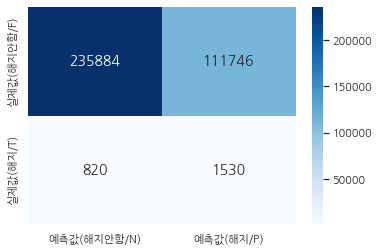

___________________________________________________________________________________________________________________________________________________________________
---------------------------------------------------------------------------feature_weights-------------------------------------------------------------------------




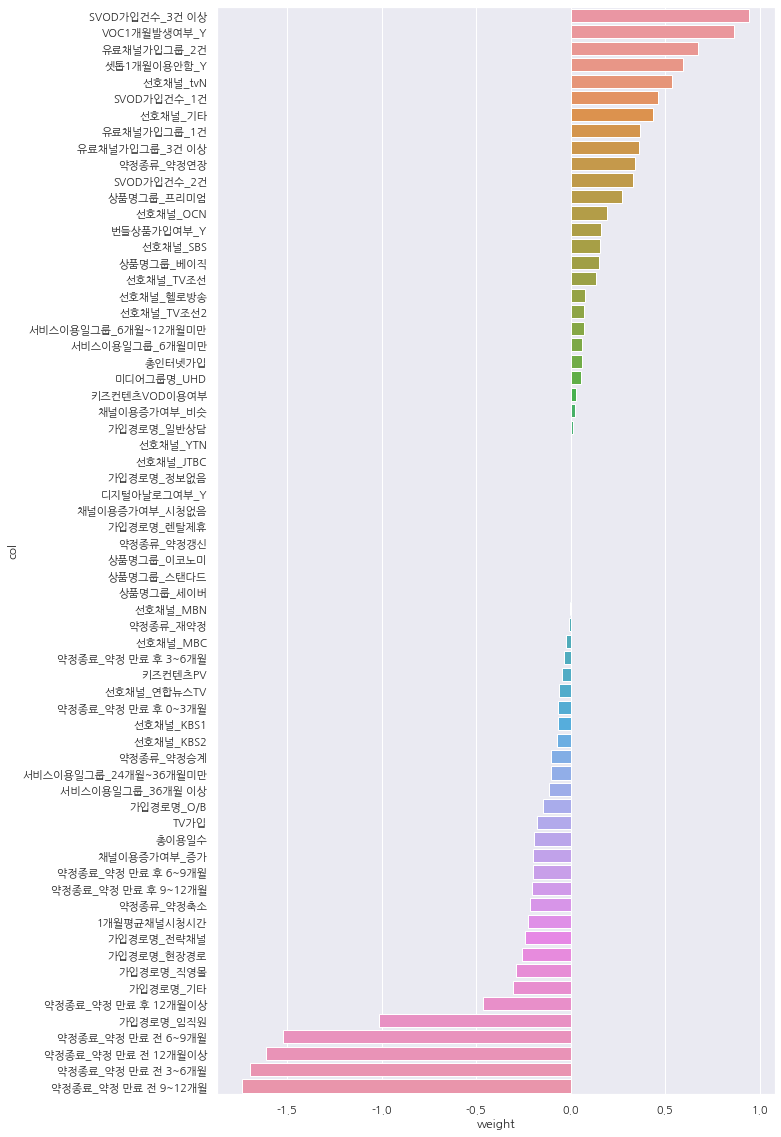

__________________________________________________________________________________________________________________________________________________________________
-------------------------------------------------------------------------ROC curve--------------------------------------------------------------------------------




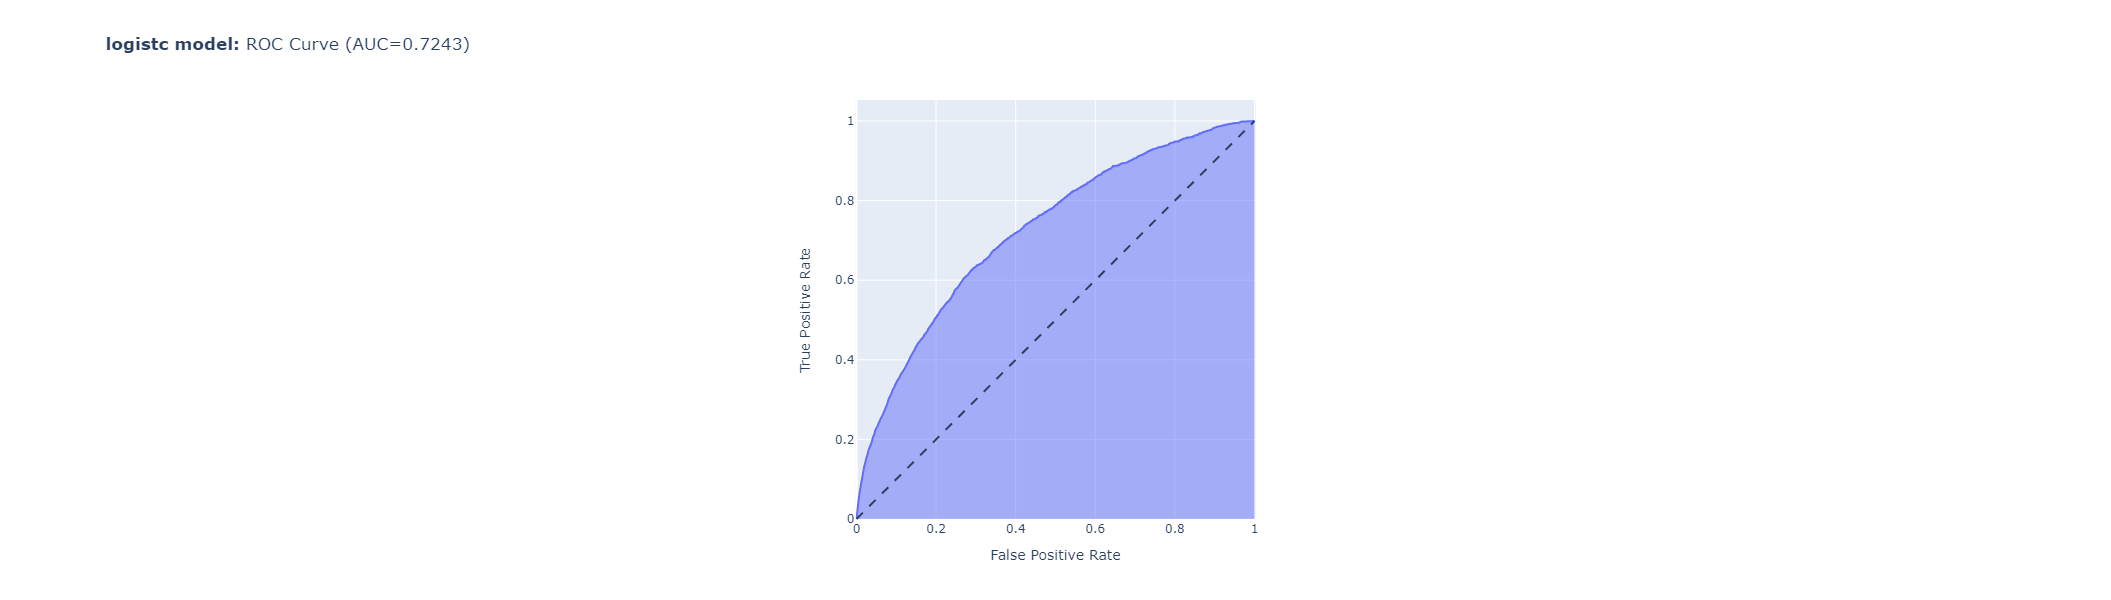

lr Model AUC: 0.7243409800466502
_________________________________________________________________________________________________________________________________________________________________________
----------------------------------------------------------------------------Classification Report------------------------------------------------------------------------


Train Dataset 성능
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      7050
           1       0.67      0.64      0.66      7050

    accuracy                           0.67     14100
   macro avg       0.67      0.67      0.67     14100
weighted avg       0.67      0.67      0.67     14100

_________________________________________________________________________________________________________________________________________________________________________
Test Dataset 성능
              precision    recall  f1-score   support

           0       1.00      0.68      0

In [47]:
logistic(X_train,y_train,X_test,y_test)

In [32]:
roc_auc_logit = auc(fpr,tpr)
roc_auc_logit

0.724340986167122

In [51]:
#logit에서 최적 threshold 찾기 
roc_result = pd.DataFrame([fpr,tpr,thresholds], index=['fpr','tpr','thresholds']).T
roc_result['best'] = (1-roc_result['fpr'])+(roc_result['tpr']) # 1종오류,2종오류 최소화

roc_result

,fpr,tpr,thresholds,best
0,0.000000,0.000000,1.999466,1.000000
1,0.000003,0.000000,0.999466,0.999997
2,0.000014,0.000000,0.967647,0.999986
3,0.000014,0.000426,0.967381,1.000411
4,0.000043,0.000426,0.961887,1.000382
...,...,...,...,...
9905,0.999853,1.000000,0.001033,1.000147
9906,0.999859,1.000000,0.000854,1.000141
9907,0.999914,1.000000,0.000335,1.000086
9908,0.999925,1.000000,0.000262,1.000075


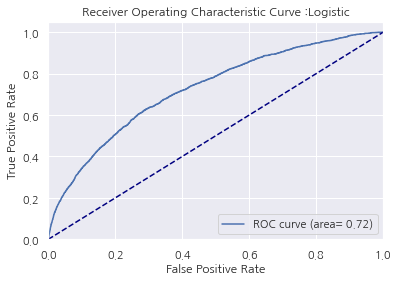

In [52]:
#lpm과 동일한 방법으로 AUROC 그리기

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc_logit)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logistic')
plt.legend(loc="lower right")

plt.show()

Best Threshold=0.967647, F-Score=nan


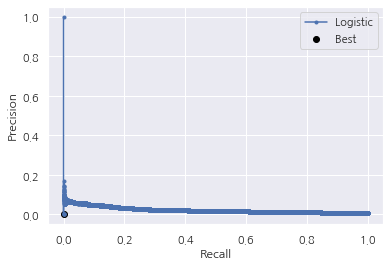

In [53]:
from numpy import argmax
# calculate pr-curve
precision, recall, thres= precision_recall_curve(y_test, y_score_lr)

# convert to f score
# fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thres[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)

pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [55]:
# 1종오류, 2종오류를 최소화하는 최적의 threshold
optimal_threshold_logit=roc_result.thresholds[roc_result.best.idxmax()]
optimal_threshold_logit

0.5170106461816616

In [61]:
y_pred_lr = [1 if x >0.5271098412207599 else 0 for x in y_score_lr]

In [62]:
tn,fp,fn,tp=confusion_matrix(y_test,y_pred_lr).ravel()
tn,fp,fn,tp

(252302, 95328, 919, 1431)

In [63]:
print(classification_report(y_test,y_pred_lr)) # accuracy 소폭상승

              precision    recall  f1-score   support

           0       1.00      0.73      0.84    347630
           1       0.01      0.61      0.03      2350

    accuracy                           0.72    349980
   macro avg       0.51      0.67      0.43    349980
weighted avg       0.99      0.72      0.83    349980



In [91]:
# # 데이터 set 생성
# check_list2 = ['총이용일수', '아날로그가입', '디지털가입', '총인터넷가입', '기가인터넷가입건수', '채널시간대별평균1달시간',
#        '아이들나라PV', '아이들나라VOD이용여부', '서비스이용일그룹_24개월~36개월미만', '서비스이용일그룹_36개월 이상',
#        '서비스이용일그룹_6개월~12개월미만', '서비스이용일그룹_6개월미만', '미디어그룹명_UHD', '상품명글룹_베이직',
#        '상품명글룹_세이버', '상품명글룹_스탠다드', '상품명글룹_이코노미', '상품명글룹_프리미엄', '약정종류_약정갱신',
#        '약정종류_약정승계', '약정종류_약정연장', '약정종류_약정축소', '약정종류_재약정', '셑탑1개월유지여부_Y',
#        'SVOD가입건수_1건', 'SVOD가입건수_2건', 'SVOD가입건수_3건 이상', '유료채널가입그룹_1건',
#        '유료채널가입그룹_2건', '유료채널가입그룹_3건 이상', '가입경로명_O/B', '가입경로명_기타', '가입경로명_렌탈제휴',
#        '가입경로명_일반상담', '가입경로명_임직원', '가입경로명_전략채널', '가입경로명_정보없음', '가입경로명_직영몰',
#        '가입경로명_현장경로', '약정종료_약정 만료 전 12개월이상', '약정종료_약정 만료 전 3~6개월',
#        '약정종료_약정 만료 전 6~9개월', '약정종료_약정 만료 전 9~12개월', '약정종료_약정 만료 후 0~3개월',
#        '약정종료_약정 만료 후 12개월이상', '약정종료_약정 만료 후 3~6개월', '약정종료_약정 만료 후 6~9개월',
#        '약정종료_약정 만료 후 9~12개월', '번들상품가입여부_Y', 'VOC1개월발생여부_Y', '채널이용증가여부_비슷',
#        '채널이용증가여부_시청없음', '채널이용증가여부_증가', '선호채널_JTBC', '선호채널_KBS1', '선호채널_KBS2',
#        '선호채널_MBC', '선호채널_MBN', '선호채널_OCN', '선호채널_SBS', '선호채널_TV조선',
#        '선호채널_TV조선2', '선호채널_YTN', '선호채널_tvN', '선호채널_기타', '선호채널_연합뉴스TV',
#        '선호채널_헬로방송']
# train_X_us2 = train_X_us[check_list2]
# test_X2 = test_X[check_list2]
# 11:01
from sklearn.linear_model import LinearRegression, Ridge, Lasso

lambda_list = [10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005]
thres_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
df_acc = pd.DataFrame(index = thres_list, columns = lambda_list)    # 정확도 값을 넣을 데이터프레임 생성
for value in lambda_list :
    # 모델 생성 및 학습
    lasso_model = Lasso(alpha = value)
    lasso_model.fit(X_train, y_train)
    # Test 데이터 예측

        
    # y_train_score_lr = lasso_model.predict_proba(X_train)[:, 1]
    y_train_pred_lr = lasso_model.predict(X_train)
    
    # test data set 
    # y_score_lr = lasso_model.predict_proba(X_test)[:, 1]
    y_pred_lr = lasso_model.predict(X_test)
    
    for thres in thres_list :
        # threshold 값 기준으로 y값 0 / 1로 분류
        Y = y_pred_lr.copy()
        Y[Y > thres] = 1
        Y[Y <= thres] = 0
        Y.astype(int)
        # Confusion matrix 생성 후 정확도 확인
        cfmat = confusion_matrix(y_test, Y)
        acc = (cfmat[0, 0] + cfmat[1, 1]) / np.sum(cfmat)
        df_acc.loc[thres, value] = acc

    

      

df_acc    # threshold가 index, alpha 값이 column인 데이터프레임



,10.000,5.000,1.000,0.500,0.100,0.050,0.010,0.005
0.1,0.006778,0.006778,0.006778,0.006778,0.006778,0.006778,0.006869,0.009458
0.2,0.006778,0.006778,0.006778,0.006778,0.006778,0.006778,0.012726,0.036185
0.3,0.006778,0.006778,0.006778,0.006778,0.006778,0.006932,0.080545,0.150966
0.4,0.006778,0.006778,0.006778,0.006778,0.006778,0.063952,0.336236,0.400614
0.5,0.993222,0.993222,0.993222,0.993222,0.993222,0.510103,0.67343,0.680842
0.6,0.993222,0.993222,0.993222,0.993222,0.993222,0.993222,0.880862,0.863064
0.7,0.993222,0.993222,0.993222,0.993222,0.993222,0.993222,0.972696,0.95826
0.8,0.993222,0.993222,0.993222,0.993222,0.993222,0.993222,0.991997,0.985373
0.9,0.993222,0.993222,0.993222,0.993222,0.993222,0.993222,0.993214,0.992262


# LASSO

In [66]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lasso_model = Lasso()
lasso_model.fit(X_train,y_train)

Lasso()

In [71]:
thres_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
df_thres = pd.DataFrame(index = threshold_list, columns = ['accuracy', 'recall'])

for thres in threshold_list :
    #print('=================== Threshold : ' + str(thres) + ' ===================')
    test_y_pred_prob = np.zeros(len(y_score_lr))
    
    
    for i in range(len(y_score_lr)):
        if  y_score_lr[i] > thres :
            test_y_pred_prob[i] = 1

    accuracy = (tp + tn) / (tp + fn + fp + tn)
    recall = tn / (fp + tn)

    df_thres.loc[thres, 'accuracy'] = accuracy
    df_thres.loc[thres, 'recall'] = recall

In [72]:
# y_train_score_lr = lasso_model.predict_proba(X_train)[:, 1]
y_train_pred_lr = lasso_model.predict(X_train)

# test data set 
# y_score_lr = lasso_model.predict_proba(X_test)[:, 1]
y_pred_lr = lasso_model.predict(X_test)

for thres in thres_list :
    # threshold 값 기준으로 y값 0 / 1로 분류
    Y = y_pred_lr.copy()
    Y[Y > thres] = 1
    Y[Y <= thres] = 0
    Y.astype(int)
    # Confusion matrix 생성 후 정확도 확인
    cfmat = confusion_matrix(y_test, Y)

In [73]:
cfmat

array([[347630,      0],
       [  2350,      0]])

In [75]:
ls_0005 = Lasso(alpha = 0.005)
ls_0005.fit(X_train, y_train)
# feature 확인
feature_selected = np.array(X_train.columns)
print(feature_selected[np.where(ls_0005.coef_ != 0)])

['총이용일수' 'TV가입' '총인터넷가입' '1개월평균채널시청시간' '서비스이용일그룹_24개월~36개월미만'
 '서비스이용일그룹_6개월~12개월미만' '서비스이용일그룹_6개월미만' '상품명그룹_이코노미' '상품명그룹_프리미엄'
 '셋톱1개월이용안함_Y' '유료채널가입그룹_1건' '가입경로명_현장경로' '약정종료_약정 만료 전 12개월이상'
 '약정종료_약정 만료 전 3~6개월' '약정종료_약정 만료 전 6~9개월' '약정종료_약정 만료 전 9~12개월'
 '약정종료_약정 만료 후 0~3개월' '번들상품가입여부_Y' 'VOC1개월발생여부_Y' '채널이용증가여부_비슷'
 '채널이용증가여부_증가' '선호채널_기타']


In [87]:
feature_selected

array(['1개월평균채널시청시간', '서비스이용일그룹_24개월~36개월미만', '서비스이용일그룹_36개월 이상',
       '서비스이용일그룹_6개월~12개월미만', '서비스이용일그룹_6개월미만', '미디어그룹명_UHD', '상품명그룹_베이직',
       '상품명그룹_세이버', '상품명그룹_스탠다드', '상품명그룹_이코노미', '상품명그룹_프리미엄', '구상품여부_Y',
       '약정종류_약정갱신', '약정종류_약정승계', '약정종류_약정연장', '약정종류_약정축소', '약정종류_재약정',
       '셋톱1개월이용안함_Y', 'SVOD가입건수_1건', 'SVOD가입건수_2건', 'SVOD가입건수_3건 이상',
       '유료채널가입그룹_1건', '유료채널가입그룹_2건', '유료채널가입그룹_3건 이상', '가입경로명_O/B',
       '가입경로명_기타', '가입경로명_렌탈제휴', '가입경로명_일반상담', '가입경로명_임직원', '가입경로명_전략채널',
       '가입경로명_정보없음', '가입경로명_직영몰', '가입경로명_현장경로', '약정종료_약정 만료 전 12개월이상',
       '약정종료_약정 만료 전 3~6개월', '약정종료_약정 만료 전 6~9개월', '약정종료_약정 만료 전 9~12개월',
       '약정종료_약정 만료 후 0~3개월', '약정종료_약정 만료 후 12개월이상', '약정종료_약정 만료 후 3~6개월',
       '약정종료_약정 만료 후 6~9개월', '약정종료_약정 만료 후 9~12개월', 'TV가입_2건',
       'TV가입_3건 이상', '아날로그가입_1건 이상', '디지털가입_2건', '디지털가입_3건 이상',
       '총인터넷가입_1건', '총인터넷가입_2건 이상', '기가인터넷가입건수_1건 이상', '번들상품가입여부_Y',
       '디지털기가가입여부_Y', '디지털아날로그여부_Y', 'TV인터넷가입건수_2건', 'TV인터넷가입건수_3건',
       'TV인터넷가입건수_4

In [79]:
print(classification_report(y_test,Y))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    347630
           1       0.00      0.00      0.00      2350

    accuracy                           0.99    349980
   macro avg       0.50      0.50      0.50    349980
weighted avg       0.99      0.99      0.99    349980



In [93]:

def evaluation(y_test,proba,pred,X_test,model):
    #score and prediction
    
    global y_score_lr, y_pred_lr, tn,fp,fn,tp
    y_score_lr = logist.predict_proba(X_test)[:, 1]
    y_pred_lr = logist.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,y_score_lr).ravel()

    print('_________________________________________________________________________________________')
    print('----------------------------------ROC curve-----------------------------------------')
    print('\n')
    # roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score_lr)

    fig = px.area(
        x=fpr, y=tpr,
        title=f'<b>{model} model:</b> ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=600, height=600
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

    print(f'lr Model AUC: {auc(fpr, tpr)}')

    print('________________________________________________________________________________________________________')
    print('----------------------------------Classification Report-----------------------------------------')
    print('\n')
    print(classification_report(y_test,y_pred_lr))


    # imbalanced data 가중 평가지표 적용
    global ir, wei_acc, wei_pre, recall
    ir = y_test.value_counts()[0]/y_test.value_counts()[1] #testset의 불균형비율
    wei_acc = (tp*ir+tn)/((tp+fn)*ir+(fp+tn))
    wei_pre = tp*ir/(tp*ir+fp)
    recall = recall_score(y_test,pred)

## XGBoost

In [22]:
def xgb(X_train, y_train, X_test, y_test):
    from xgboost import XGBClassifier, plot_importance
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
    from sklearn.feature_selection import RFE
    
    

    xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
    xgb.fit(X_train,y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_pred_proba= xgb.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,xgb_pred)

    fig = px.area(
        x=fpr, y=tpr,
        title=f'<b>Undersampled XGB Model:</b> ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=600, height=600
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()
    
    
    print(classification_report(y_test,xgb_pred))
    print(confusion_matrix(y_test,xgb_pred))
    

In [77]:
xgbc = XGBClassifier(n_estimators=400,learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:,1]

In [84]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83    347630
           1       0.01      0.63      0.03      2350

    accuracy                           0.71    349980
   macro avg       0.51      0.67      0.43    349980
weighted avg       0.99      0.71      0.82    349980

